# DeepLabV3
<u>Project Title</u>: Supervised Robot Tool Image Segmentation and Generation Methods \
<u>Group: 16</u> \
<u>Authors:</u> Aryaman Shodhan ashodha1,
Trisha Karani tkarani1,
Shreya Wadhwa swadhwa5,
Aidan Aug aaug1

---

**Notebook description**: This Colab Notebook implements the DeepLabV3, first proposed here:[https://arxiv.org/abs/1706.05587]



# Setup: 

Mounting Drive, importing libraries, and determining device

In [ ]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
from datetime import datetime
from pytz import timezone
tz = timezone('US/Eastern')

In [ ]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

In [ ]:
import random
random.seed(3407)
torch.manual_seed(3407)
np.random.seed(3407)

# Data Preprocessing

NOTE: MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE CholecSeg8k DATA!!!

The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Shuffles the data
3. Splits data into an 60:10:10 train-val-test split
4. Generates an ImageDataset class based on this data for feeding into a dataloader
5. Resizes images into 192 x 320 pixel images
6. Visualizes data

In [ ]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
# data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan

mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [ ]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [ ]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None), #Ratios must be compatible with DeepLabv3
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 20
Batches of Validation Dataloader: 4
Batches of Testing Dataloader: 100


### Visualize Data

In [ ]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

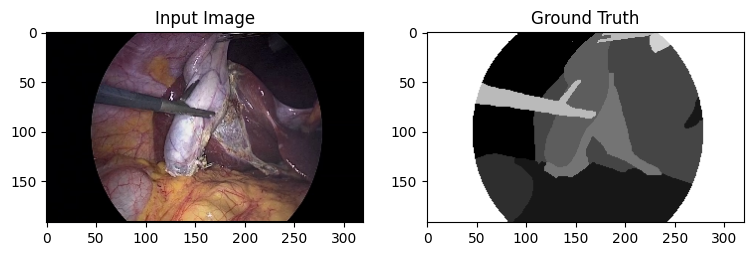

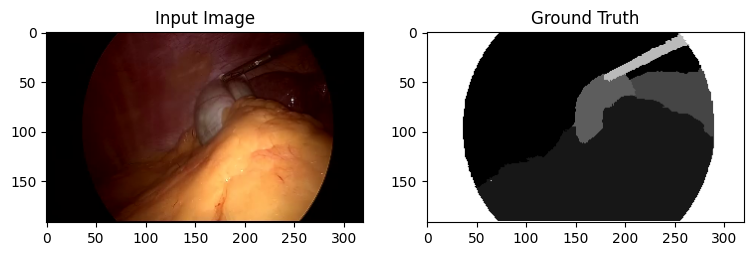

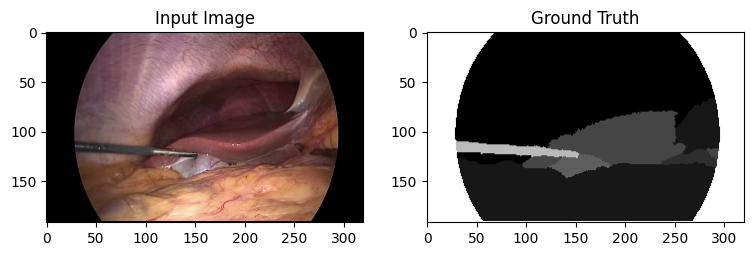

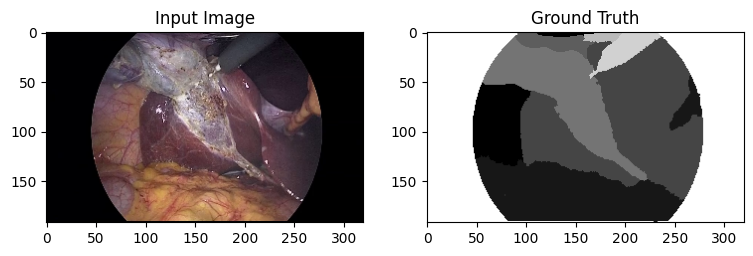

In [ ]:
visualize(train_dataloader, n_samples=4)

# Loss Functions

TODO: INCLUDE DESCRIPTION OF RATIONALE BEHIND DICELOSS AND IOU

Dice Loss

Remember to include references about where we got the equation from!

https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf

In [ ]:
# IOU Loss = 1 - (|A intersect B| / |A union B|)
class IOULoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(IOULoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks, n_classes):
    batch_size = target_masks.shape[0]
    iou_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      iou_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        iou_classes[cl] = intersection / (predicted_mask[cl].sum() + target_mask[cl].sum() - intersection)
      iou_scores[batch] = iou_classes.mean()
    return 1.0 - iou_scores.mean()

In [ ]:
# DICE Loss = 1 - (2 * |A intersect B| / (|A| + |B|))
class DICELoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(DICELoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks):
    n_classes = predicted_masks.shape[1]
    batch_size = target_masks.shape[0]
    dice_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      dice_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        dice_classes[cl] = 2 * intersection / (predicted_mask[cl].sum() + target_mask[cl].sum())
      dice_scores[batch] = dice_classes.mean()
    return 1.0 - dice_scores.mean()

In [ ]:
## Loss Functions Testing

# Batch has 1 item with 3 classes
predicted = torch.Tensor([
    # Class 1
    [[[0.2, 0.1, 0.05],
    [0.1, 0.3, 0.4],
    [0.6, 0.75, 0.25]],

    # Class 2
    [[0.25, 0.1, 0.9],
    [0.45, 0.2, 0.3],
    [0.2, 0.15, 0.05]],

    # Class 3
    [[0.55, 0.8, 0.05],
    [0.45, 0.5, 0.3],
    [0.2, 0.1, 0.7]]]
])

# Batch has 1 item with 3 classes
target = torch.Tensor([
    # Class 1
    [[[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0]],

    # Class 2
    [[1, 0, 1],
    [0, 1, 0],
    [0, 1, 0]],

    # Class 3
    [[0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]]
])

# IOU Score for Class 1: 1.0 / (2.0 + 2.75 - 1.0) = 0.2667
# IOU Score for Class 2: 1.5 / (4.0 + 2.6 - 1.5) = 0.2941
# IOU Score for Class 3: 1.95 / (3.0 + 3.65 - 1.95) = 0.4149
# Mean IOU Score: 0.3252
# Loss = 1 - 0.3252 = 0.6748
iou = IOULoss()
iou_loss = iou.forward(predicted, target, n_classes=3).item()
assert(iou_loss == 0.6747740507125854)

# DICE Score for Class 1: 2 * 1.0 / (2.0 + 2.75) = 0.4211
# DICE Score for Class 2: 2 * 1.5 / (4.0 + 2.6) = 0.4545
# DICE Score for Class 3: 2 * 1.95 / (3.0 + 3.65) = 0.5865
# Mean DICE Score: 0.4874
# Loss = 1 - 0.4874 = 0.5126
dice = DICELoss()
# dice_loss = dice.forward(predicted, target, n_classes=3).item()
dice_loss = dice.forward(predicted, target).item()

assert(dice_loss == 0.5126452445983887)

In [ ]:
def dice_score_image(prediction, target, n_classes):
    dice_classes = np.zeros(n_classes)

    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, use_gpu=False, is_deeplab_or_fcn=False):
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)

    model.eval()
    idx = 0
    for data in dataloader:

        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()

        out = model(img)
        if is_deeplab_or_fcn:
          out = out['out']
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = nn.functional.one_hot(prediction, n_classes)
        prediction = prediction.permute(0, 3, 1, 2)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1

    m_dice = scores.mean()
    return m_dice

# Training and Validation

In [ ]:
def test_eval(test_dataloader, model, loss, is_deeplab_or_fcn=False, verbose = 1):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          if i <= 5:
            fig, ax = plt.subplots(1, 3)
            img = outputs[0]
            img = np.argmax(img.cpu().numpy(), axis=0)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title("Predicted")    

            ax[1].imshow(np.argmax(labels[0].cpu().numpy(), axis=0), cmap="gray")
            ax[1].set_title("Labels")

            input = images[0].permute(1, 2, 0).cpu().numpy()
            ax[2].imshow(input)
            ax[2].set_title("Input")

            plt.show()
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def val_eval(val_dataloader, model, loss, is_deeplab_or_fcn=False, verbose = 0):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Val loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def train(model, train_data_loader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False):

  loss_fail = 0
  patience = 5
  best_model = model
  best_val_loss = float('inf')
  n_classes = 13
  print("Start Training...")
  print("{:<10} {:<20} {:<20} {:<20} {:<15} {:<15}".format('epoch', 'train loss','val loss', 'es_counter(/5)', 'min_val_loss', 'time(s)'))
  time_start = time.time() #timekeeping
  for epoch in range(num_epochs):
      ########################### Training #####################################
      time_epoch_start = time.time() #timekeeping
      loss_sum = 0
      correct = 0
      total = 0
      for i, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        if is_deeplab_or_fcn:
          outputs = outputs['out'] #only for DeepLabV3
        loss_val = loss(outputs, y)
        loss_val.backward()
        optimizer.step()

        # train eval
        loss_sum += loss_val.item()
        total += y.size(0)

      train_loss = loss_sum / total
      ########################### Validation #####################################
      val_loss = val_eval(validation_dataloader, model, loss, is_deeplab_or_fcn)

      # Early Stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        loss_fail = 0
      else:
        loss_fail += 1
      
      if loss_fail == patience:
          print("Stopping Early..")
          print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n", "Train Loss:",train_loss, "Validation Loss:",val_loss)
          break

      # Timekeeping
      time_epoch_end = time.time()
      total_time = time_epoch_end - time_start

      # Print statements + data keeping for graph
      if epoch % 2 == 0:
          print("{:<10} {:<20f} {:<20f} {:<20d} {:<15f} {:<15f}".format(
            epoch, train_loss, val_loss, loss_fail, round(best_val_loss,10), total_time))
      if epoch == 0:
          L = train_loss
          A = val_loss
      else:
          L = np.append(L,train_loss)
          A = np.append(A,val_loss)

  ## Plot Training Loss and Validation Loss
  plt.plot(L,'-', label='Training Loss')
  plt.plot(A,'-', label='Validation Loss')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='best')
  plt.show()

  return best_model

# EXPERIMENT 1 Comparing different segmentation models

This notebook explores the performance of a DeepLabV3 model for image segmentation and in Experiment 1, we will be retraining the entire model.

## DeepLabV3

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.066040             0.035692             0                    0.035692        125.986002     
2          0.016070             0.016585             0                    0.016585        331.084233     
4          0.008162             0.008492             0                    0.008492        537.309263     
6          0.004667             0.005234             0                    0.005234        743.014235     
8          0.006057             0.006353             2                    0.005234        948.148109     
10         0.003537             0.004369             0                    0.004369        1152.537251    
12         0.002823             0.003713             0                    0.003713        1358.090223    
14         0.002558             0.003724             1                    0.003663        1567.577695    
16         0.002954         

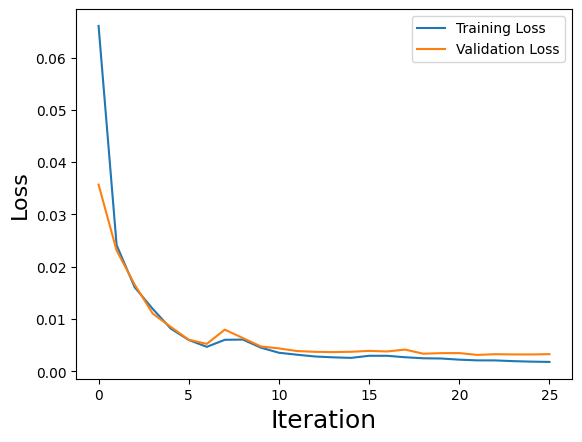

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet50()

model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 13, kernel_size=1, stride=1)
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_trained, test_dataloader, use_gpu, True)

0.9444627459545438

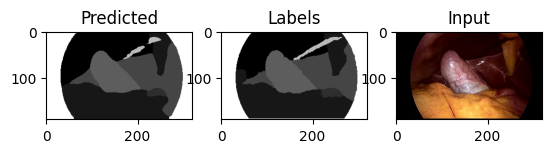

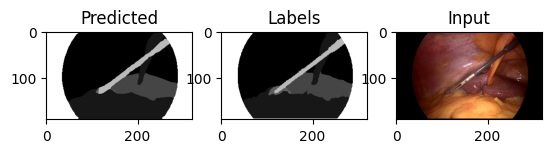

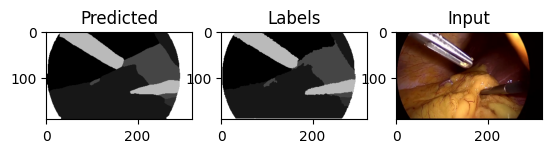

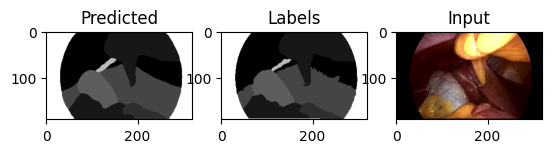

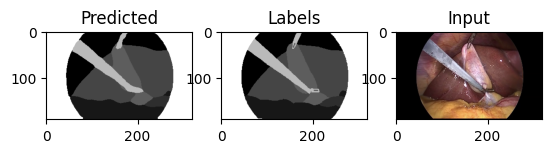

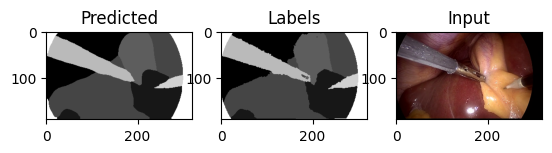

Test loss: 0.139287


0.13928651892329277

In [ ]:
test_eval(test_dataloader, deeplabV3_trained, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_trained, data_dir + f"saved_models/models/deeplabV3_trained_{cur_time}.pt")

# EXPERIMENT 2 TRANSFER LEARNING USING A SPECIFIC MODEL

This notebook explores the performance of a DeepLabV3 model for image segmentation and in Experiment 2, we will be only be retraining the last layer of the model.

## DeepLabV3

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.048388             0.035936             0                    0.035936        89.327622      
2          0.019568             0.022359             0                    0.022359        266.138087     
4          0.014701             0.015973             0                    0.015973        438.080325     
6          0.011428             0.014346             0                    0.014346        614.087572     
8          0.011059             0.013831             0                    0.013831        786.556405     
10         0.009063             0.011353             0                    0.011353        959.596593     
12         0.008277             0.011336             1                    0.010471        1131.572612    
14         0.008836             0.010606             3                    0.010471        1305.062752    
Stopping Early..

EPOCH 17 o

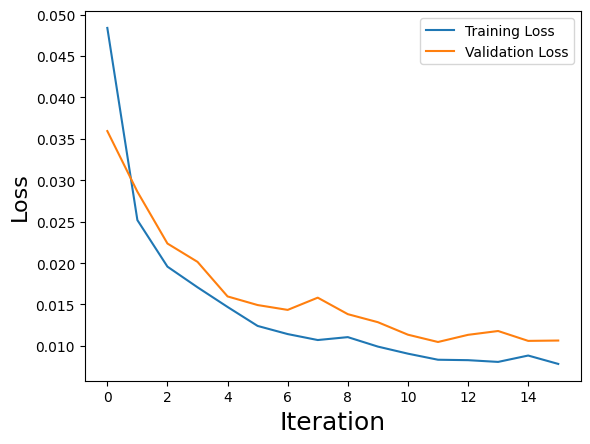

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_transfer = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_transfer, test_dataloader, use_gpu, True)

0.8574547860356101

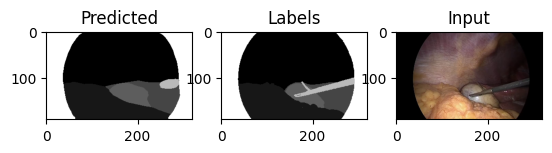

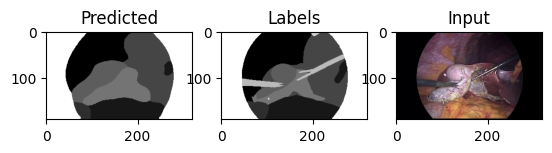

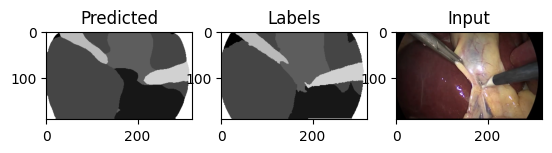

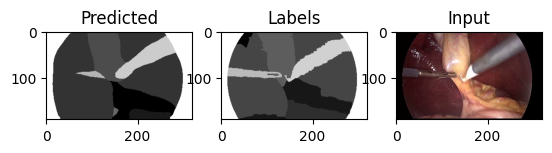

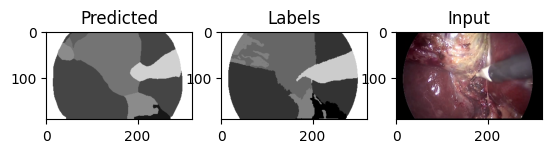

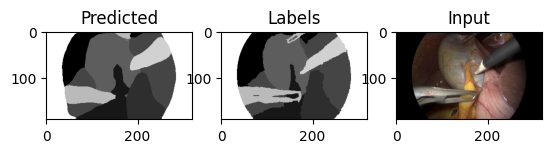

Test loss: 0.298386


0.29838649934166855

In [ ]:
test_eval(test_dataloader, deeplabV3_transfer, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_transfer, data_dir + f"saved_models/models/deeplabV3_transfer_{cur_time}.pt")

# EXPERIMENT 3: RECOLORIZATION

Model pretrained on the unsupervized recolorization task can be found at 'path_to_main_directory/saved_models/models/deep_lab_image_recolorization.pt' 


## DeepLabV3

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.058957             0.042553             0                    0.042553        92.671674      
2          0.024317             0.026729             0                    0.026729        272.811714     
4          0.017627             0.020374             0                    0.020374        451.622223     
6          0.014583             0.016839             0                    0.016839        638.416314     
8          0.012858             0.014409             0                    0.014409        820.211313     
10         0.011905             0.013115             0                    0.013115        1003.385401    
12         0.010199             0.011715             0                    0.011715        1188.296623    
14         0.009717             0.010434             0                    0.010434        1367.939132    
16         0.008629         

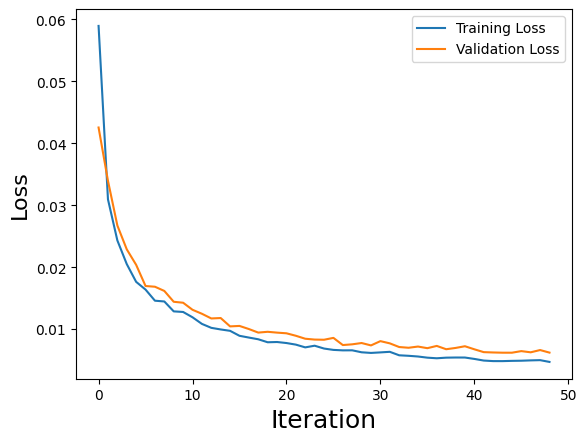

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/deep_lab_image_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_recolored_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_recolored_segmentation, test_dataloader, use_gpu, True)

0.8851661529057664

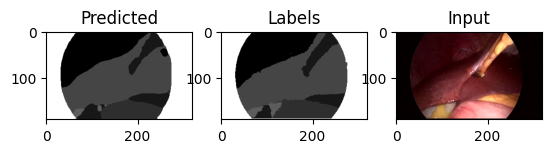

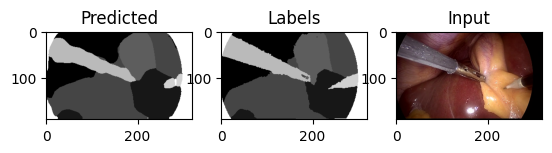

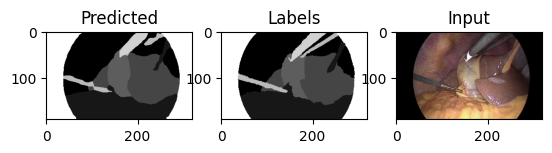

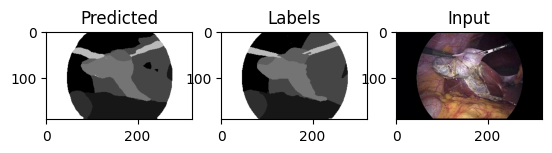

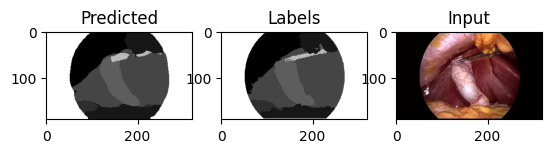

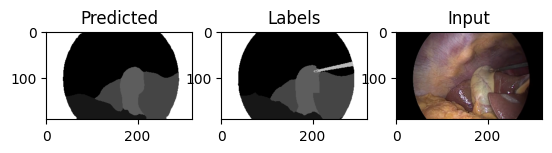

Test loss: 0.199466


0.19946592358549164

In [ ]:
test_eval(test_dataloader, deeplabV3_recolored_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_recolored_segmentation, data_dir + f"saved_models/models/deeplabV3_recolored_segmentation_{cur_time}.pt")

### With 50% GAN Images

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.070189             0.043594             0                    0.043594        957.543350     
2          0.025243             0.028674             0                    0.028674        1144.479268    
4          0.019319             0.020965             0                    0.020965        1324.627401    
6          0.016953             0.018057             0                    0.018057        1507.465718    
8          0.013721             0.015277             0                    0.015277        1693.548588    
10         0.011448             0.013348             0                    0.013348        1874.756778    
12         0.010706             0.013861             1                    0.012387        2055.366725    
14         0.009930             0.011369             0                    0.011369        2241.220481    
16         0.008852         

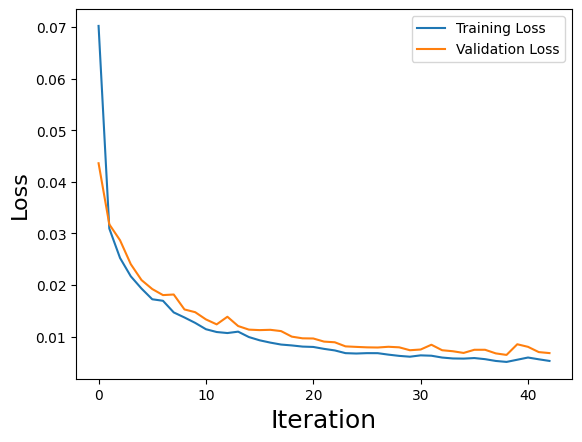

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/deep_lab_GAN_image_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_GAN_recolored_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_GAN_recolored_segmentation, test_dataloader, use_gpu, True)

0.8777728654806954

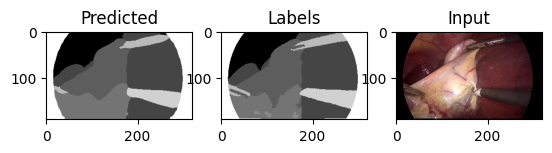

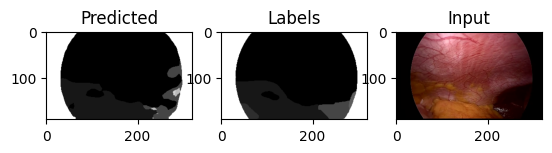

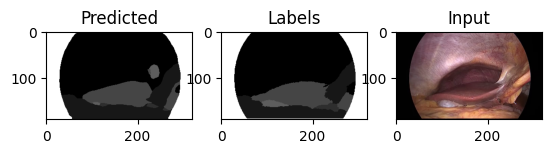

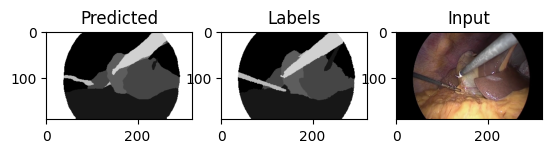

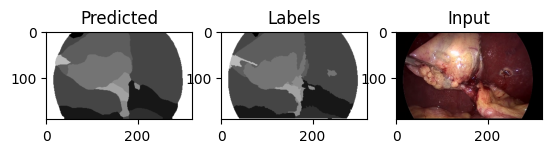

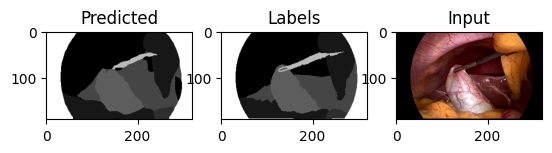

Test loss: 0.157552


0.15755157226754757

In [ ]:
test_eval(test_dataloader, deeplabV3_GAN_recolored_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_GAN_recolored_segmentation, data_dir + f"saved_models/models/deeplabV3_GAN_recolored_segmentation_{cur_time}.pt")

### With 100% GAN Images

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.074559             0.046718             0                    0.046718        85.421927      
2          0.025301             0.026904             0                    0.026904        256.690861     
4          0.017802             0.021031             0                    0.021031        436.986947     
6          0.014407             0.016823             0                    0.016823        613.823846     
8          0.011722             0.013339             0                    0.013339        785.574777     
10         0.009710             0.011509             0                    0.011509        960.718222     
12         0.008688             0.010441             0                    0.010441        1133.022190    
14         0.008075             0.010360             1                    0.009360        1312.134658    
16         0.007379         

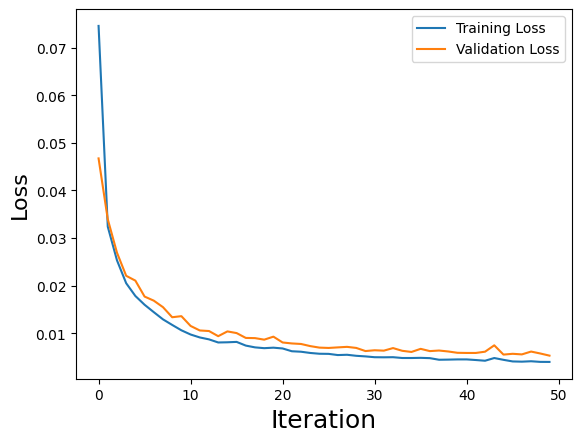

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/deep_lab_GAN_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_GAN_100_recolored_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_GAN_100_recolored_segmentation, test_dataloader, use_gpu, True)

0.9018166000522325

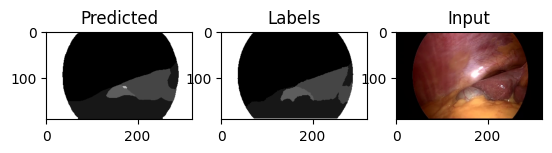

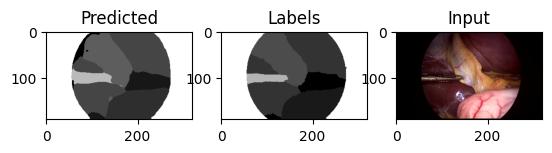

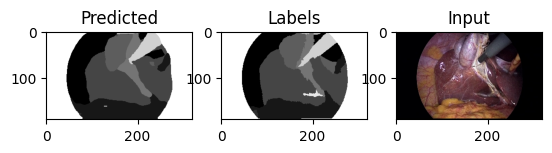

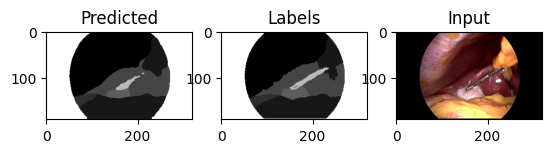

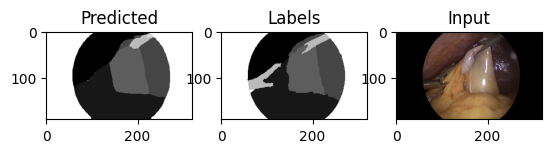

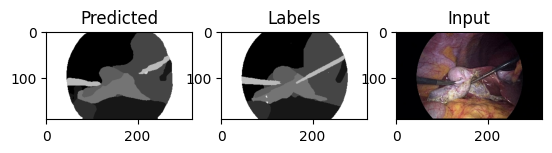

Test loss: 0.132005


0.13200544417298193

In [ ]:
test_eval(test_dataloader, deeplabV3_GAN_100_recolored_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_GAN_100_recolored_segmentation, data_dir + f"saved_models/models/deeplabV3_GAN_100_recolored_segmentation_{cur_time}.pt")

# EXPERIMENT 4: DATA AUGMENTATION

Here, we apply RandomHorizontalFlip() and RandomVerticalFlip() to generate valid data augmentations


## Apply Data Augmentation

In [ ]:
# Redefine ImageDataset
class ImageDatasetDataAug(Dataset):
  def __init__(self, data, mask_json, req_transforms=None, data_aug=[]):
    self.data = data
    self.mask_json = mask_json
    self.transforms = req_transforms
    self.data_aug = data_aug


    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    for i in range(len(self.data_aug)):
      if random.random() > 0.5:
        data_aug = self.data_aug[i]
        img = data_aug(img)
        mask = data_aug(mask)


    return img, mask

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1


data_aug = [transforms.functional.vflip, transforms.functional.hflip]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


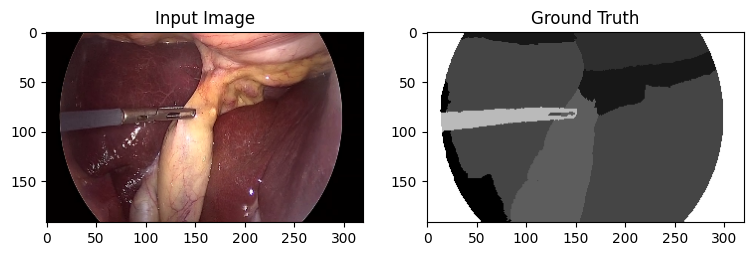

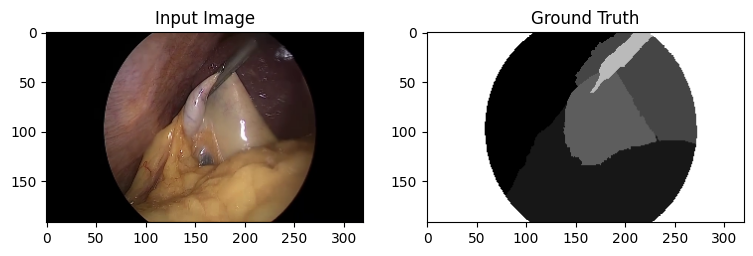

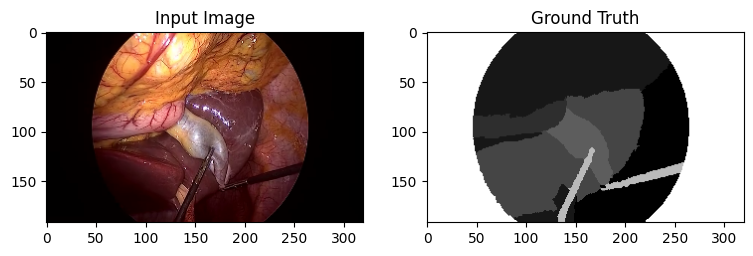

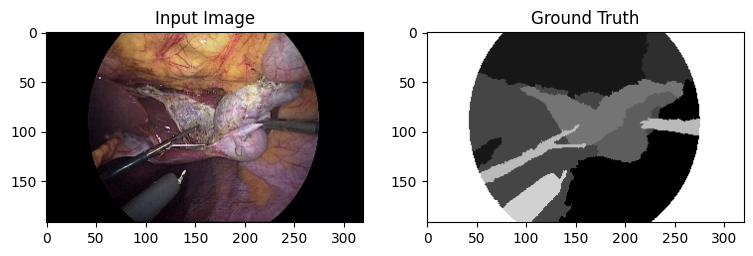

In [ ]:
visualize(train_dataloader, n_samples=4)

## DeepLabV3

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.079235             0.078179             0                    0.078179        583.979298     
2          0.025321             0.054541             1                    0.047771        797.253898     
4          0.015385             0.053852             3                    0.047771        1011.151377    
6          0.009987             0.060306             1                    0.039796        1226.186425    
8          0.006462             0.019559             0                    0.019559        1438.580470    
10         0.005445             0.027618             2                    0.019559        1649.743826    
12         0.004781             0.022099             4                    0.019559        1861.872900    
Stopping Early..

EPOCH 14 of 50
 Train Loss: 0.004363754306599297 Validation Loss: 0.019590295990677634


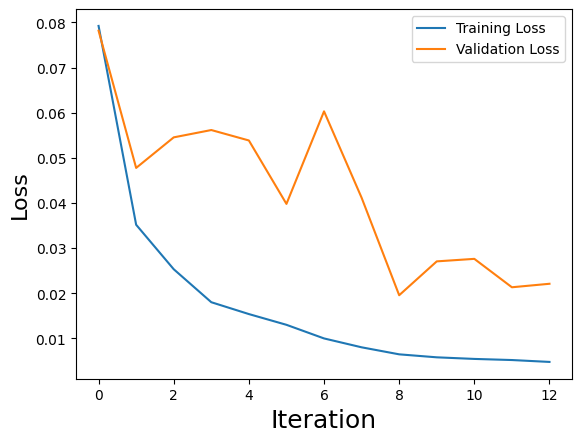

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet50()

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_trained_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_trained_aug, test_dataloader, use_gpu, True)

0.9049582156695558

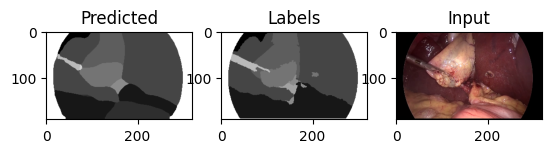

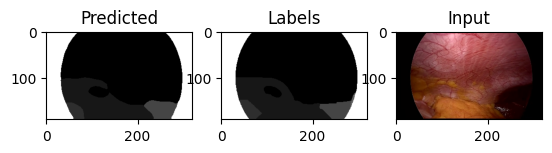

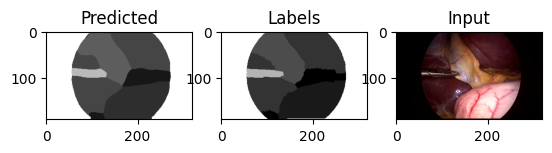

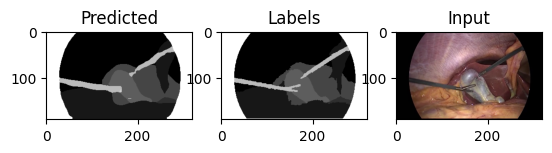

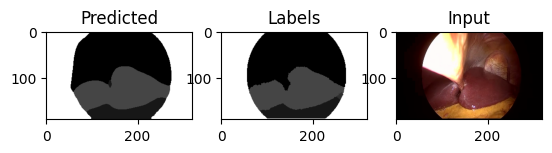

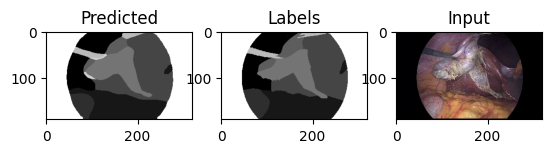

Test loss: 0.130921


0.13092104574060467

In [ ]:
test_eval(test_dataloader, deeplabV3_trained_aug, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_trained_aug, data_dir + f"saved_models/models/deeplabV3_trained_aug_{cur_time}.pt")

# EXPERIMENT 5: Adversarial Augmentation

Here, we add random noise to the data to mimic an Adversarial Attack in order to make the model more robust

## Apply Data Augmentation

In [ ]:
def noise(img):
  mean = 0.0
  std = 0.1
  noise = torch.normal(mean, std, size=img.shape[-2:])
  new_img = img + noise.unsqueeze(0)
  return new_img

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1


data_aug = [noise]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


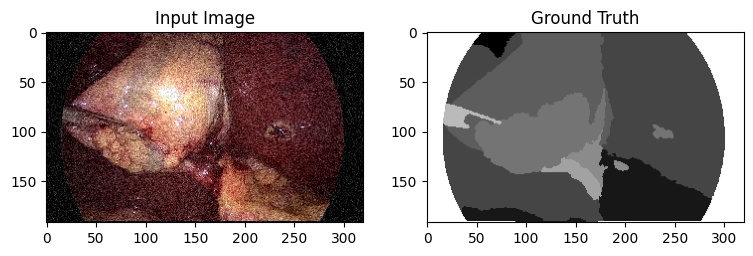

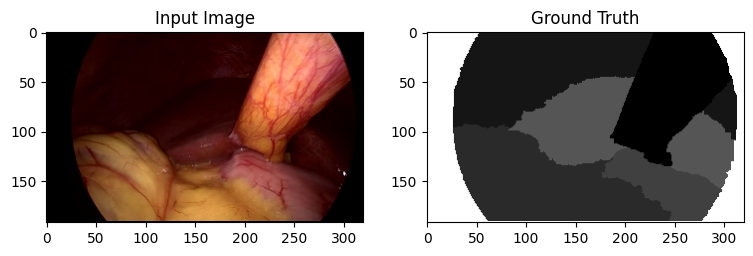

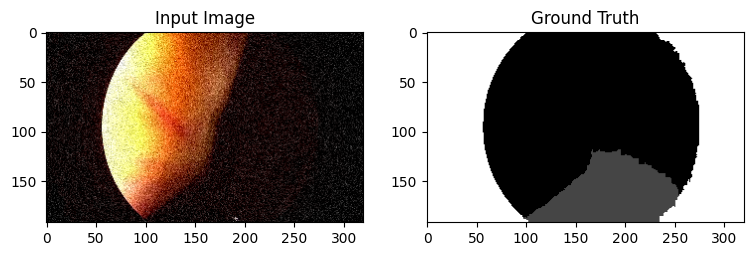

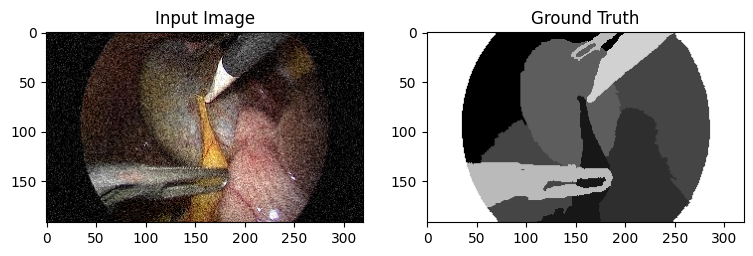

In [ ]:
visualize(train_dataloader, n_samples=4)

## DeepLabV3

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.079320             0.055180             0                    0.055180        585.288378     
2          0.028326             0.027407             0                    0.027407        814.477261     
4          0.014775             0.014627             0                    0.014627        1040.288473    
6          0.009136             0.009018             0                    0.009018        1265.912158    
8          0.005771             0.007025             0                    0.007025        1500.503856    
10         0.004663             0.005583             0                    0.005583        1735.194499    
12         0.004855             0.006229             1                    0.005197        1971.677060    
14         0.004400             0.005037             0                    0.005037        2197.371403    
16         0.003662         

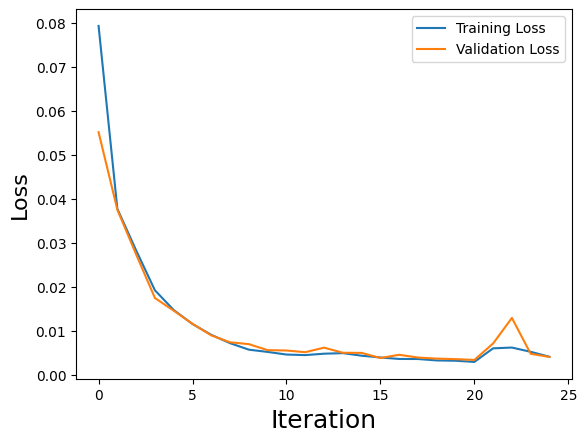

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.deeplabv3_resnet50()

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
deeplabV3_trained_noise = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(deeplabV3_trained_noise, test_dataloader, use_gpu, True)

0.9377500048650705

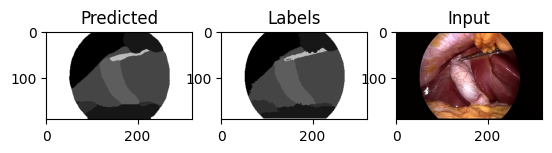

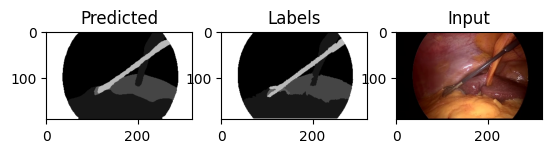

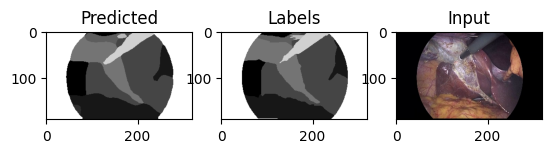

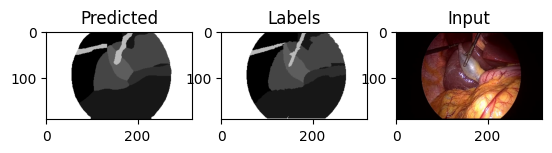

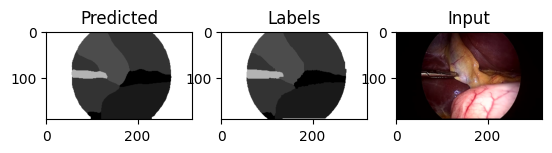

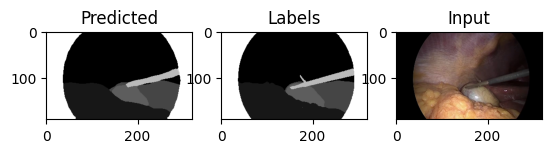

Test loss: 0.121395


0.12139516489035042

In [ ]:
test_eval(test_dataloader, deeplabV3_trained_noise, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(deeplabV3_trained_noise, data_dir + f"saved_models/models/deeplabV3_trained_noise_{cur_time}.pt")